# Trabajo práctico 3
## Alumno: Lucas Barrera
### Contenido
Encontrar el logotipo de la gaseosa dentro de las imágenes provistas en Material_TPs/TP3/images a partir del template Material_TPs/TP3/template
1. (4 puntos) Obtener una detección del logo en cada imagen sin falsos positivos
2. (4 puntos) Plantear y validar un algoritmo para múltiples detecciones en la imagen coca_multi.png con el mismo témplate del ítem 1
3. (2 puntos) Generalizar el algoritmo del item 2 para todas las imágenes.

Visualizar los resultados con bounding boxes en cada imagen mostrando el nivel de confianza
de la detección.

## Resolución
#### Funciones de utilidad

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def open_image_and_detect_edges(path, canny_thr1, canny_thr2):
    bgr_image = cv2.imread(path)

    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    gray_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)

    gray_image = cv2.GaussianBlur(gray_image, (3, 3), 0)

    image_edges = cv2.Canny(
        gray_image, threshold1=canny_thr1, threshold2=canny_thr2)

    return rgb_image, image_edges


def draw_bounding_box_with_text(image, bbox_start, bbox_end, label):
    (label_width, label_height), _ = cv2.getTextSize(
        label, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)

    text_end = (bbox_start[0] + label_width, bbox_start[1] - label_height)

    cv2.rectangle(image, bbox_start, bbox_end, (0, 0, 0), 2)
    
    cv2.rectangle(image, bbox_start, text_end, (0, 0, 0), -1)
    cv2.rectangle(image, bbox_start, text_end, (0, 0, 0), 2)

    cv2.putText(image, label, bbox_start,
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

# from: https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/


def calculate_iou(start_A, start_B, width, height):
    end_A = [start_A[0] + width, start_A[1] + height]
    end_B = [start_B[0] + width, start_B[1] + height]

    xA = max(start_A[0], start_B[0])
    yA = max(start_A[1], start_B[1])
    xB = min(end_A[0], end_B[0])
    yB = min(end_A[1], end_B[1])

    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    boxAArea = (end_A[0] - start_A[0] + 1) * (end_A[1] - start_A[1] + 1)
    boxBArea = (end_B[0] - start_B[0] + 1) * (end_B[1] - start_B[1] + 1)

    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou


#### Algoritmo de detección

In [3]:
def detect_template(template_path: str, image_path: str, multi_detection: bool = False):
    TEMPLATE_METHOD = cv2.TM_CCOEFF_NORMED
    BASE_DOWNSCALE = 0.96
    COEFF_COMPENSATION = 0.98
    MIN_TEMPLATE_SIZE_RATIO = 0.12
    TRESHOLD_MAX_RATIO = 0.8
    TRESHOLD_IOU = 0.7

    image_rgb, image_edges = open_image_and_detect_edges(image_path, 300, 450)
    image_h, image_w = image_edges.shape

    _, template_edges = open_image_and_detect_edges(template_path, 0, 100)
    template_h, template_w = template_edges.shape

    scale = min(image_w/template_w, image_h/template_h)
    template_edges = image = cv2.resize(
        template_edges, None, fx=scale, fy=scale)

    MIN_TEMPLATE_SIDE_SIZE = min(
        template_edges.shape) * MIN_TEMPLATE_SIZE_RATIO

    temp_template_edges = template_edges.copy()

    max_values = []
    i = 1

    while (min(temp_template_edges.shape) > MIN_TEMPLATE_SIDE_SIZE):
        match_result = cv2.matchTemplate(
            image_edges, temp_template_edges, TEMPLATE_METHOD)

        compensated_max_value = np.max(
            match_result) * np.power(COEFF_COMPENSATION, (i-1))

        max_values.append(compensated_max_value)

        scale = np.power(BASE_DOWNSCALE, i)
        temp_template_edges = cv2.resize(
            template_edges, None, fx=scale, fy=scale)

        i += 1

    index_max = max_values.index(max(max_values))
    scale = np.power(BASE_DOWNSCALE, index_max)

    template_edges = cv2.resize(template_edges, None, fx=scale, fy=scale)
    template_h, template_w = template_edges.shape

    match_result = cv2.matchTemplate(
        image_edges, template_edges, TEMPLATE_METHOD)

    threshold = np.max(match_result) * TRESHOLD_MAX_RATIO
    loc = np.where(match_result >= threshold)
    points = list(zip(*loc[::-1]))

    points_confidence = []

    for point in points:
        confidence = match_result[point[1], point[0]]
        points_confidence.append([point, confidence])

    points_confidence.sort(key=lambda pc: pc[1], reverse=True)

    filtered_points = []

    for point, confidence in points_confidence:
        if len(filtered_points) == 0:
            filtered_points.append([point, confidence])
            if not multi_detection:
                break
        elif np.any([calculate_iou(point, fpoint, template_w, template_h) < TRESHOLD_IOU for fpoint, _ in filtered_points]):
            filtered_points.append([point, confidence])

    for fpoint, confidence in filtered_points:
        draw_bounding_box_with_text(
            image_rgb, fpoint, (fpoint[0] + template_w, fpoint[1] + template_h), f'{int(confidence*100)}%')

    print("Detecciones:", len(filtered_points))

    plt.imshow(image_rgb)
    plt.show()


In [4]:
IMAGES_PATH = './data/images/'
TEMPLATE_PATH = './data/template/pattern.png'

##### Ejercicio 1

Detecciones: 1


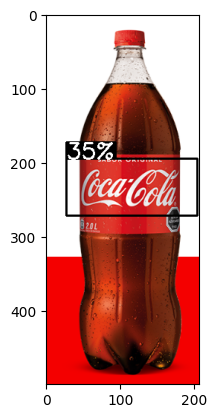

Detecciones: 1


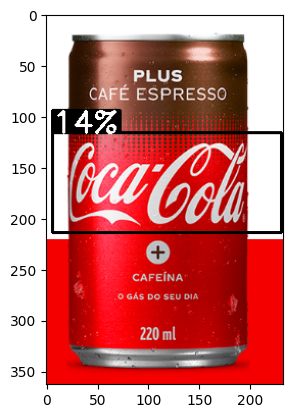

Detecciones: 1


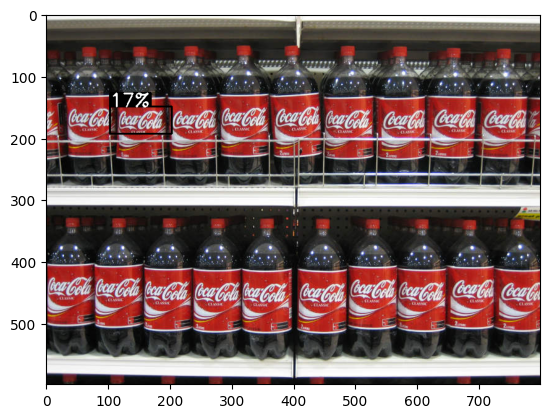

Detecciones: 1


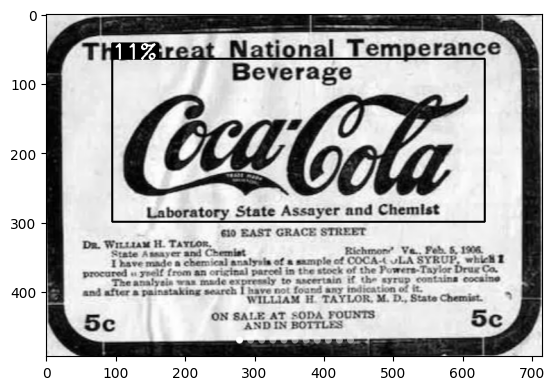

Detecciones: 1


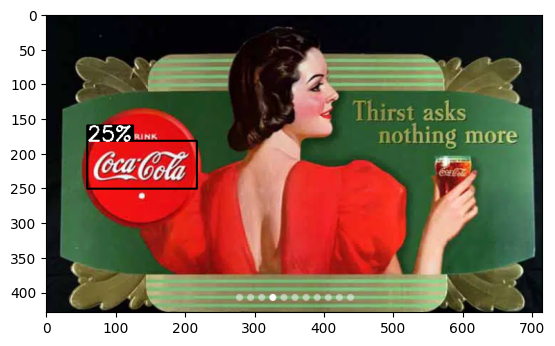

Detecciones: 1


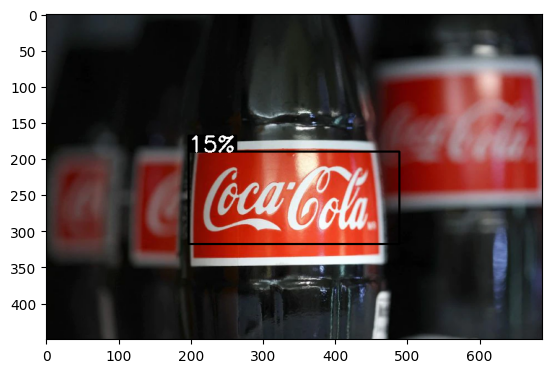

Detecciones: 1


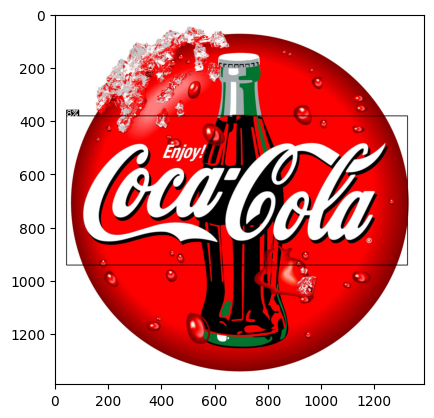

In [5]:
detect_template(TEMPLATE_PATH, IMAGES_PATH + 'coca_logo_1.png')
detect_template(TEMPLATE_PATH, IMAGES_PATH + 'coca_logo_2.png')
detect_template(TEMPLATE_PATH, IMAGES_PATH + 'coca_multi.png')
detect_template(TEMPLATE_PATH, IMAGES_PATH + 'coca_retro_1.png')
detect_template(TEMPLATE_PATH, IMAGES_PATH + 'coca_retro_2.png')
detect_template(TEMPLATE_PATH, IMAGES_PATH + 'logo_1.png')
detect_template(TEMPLATE_PATH, IMAGES_PATH + 'COCA-COLA-LOGO.jpg')

#### Ejercicio 2

Detecciones: 5


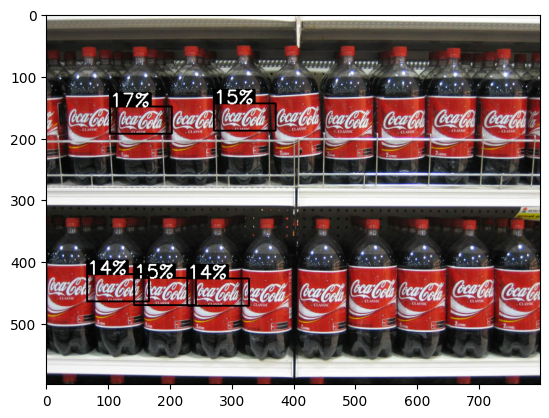

In [6]:
detect_template(TEMPLATE_PATH, IMAGES_PATH + 'coca_multi.png', True)

#### Ejercicio 3

Detecciones: 1


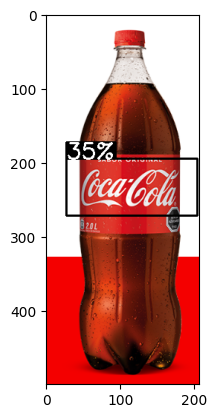

Detecciones: 1


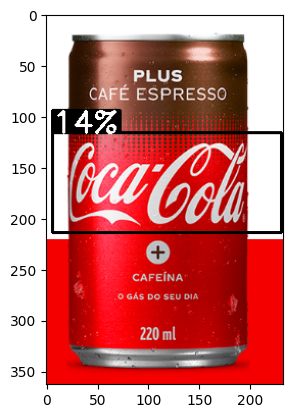

Detecciones: 5


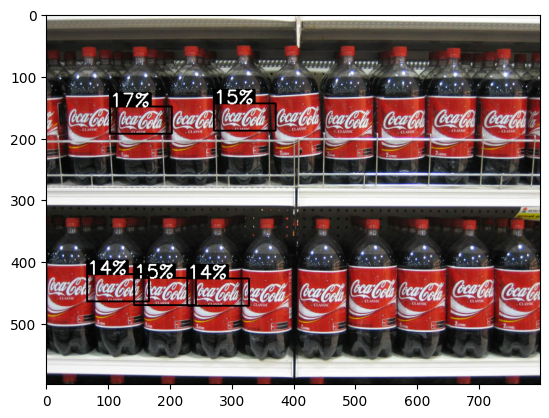

Detecciones: 1


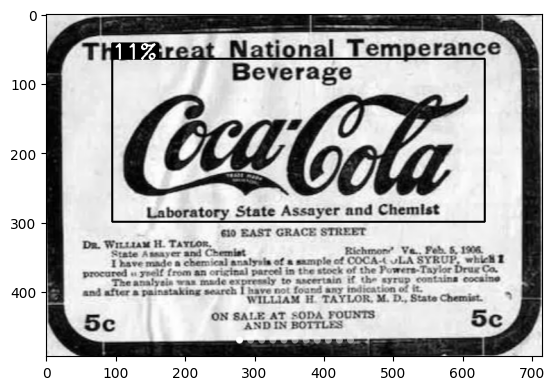

Detecciones: 1


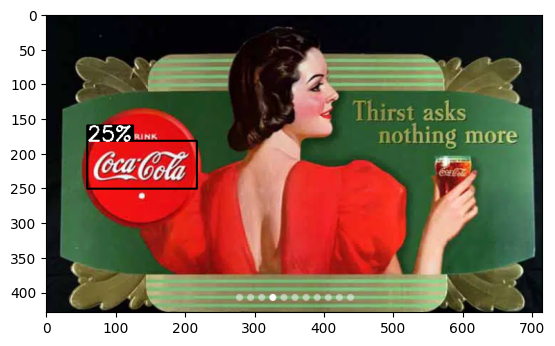

Detecciones: 1


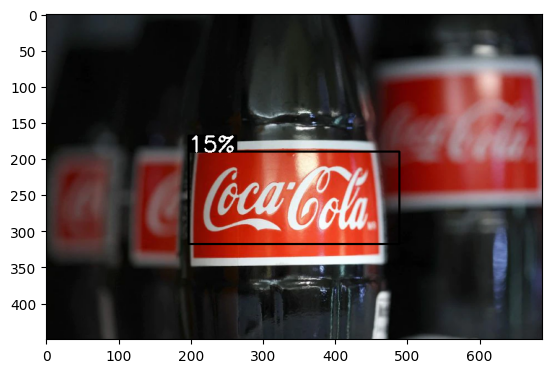

Detecciones: 1


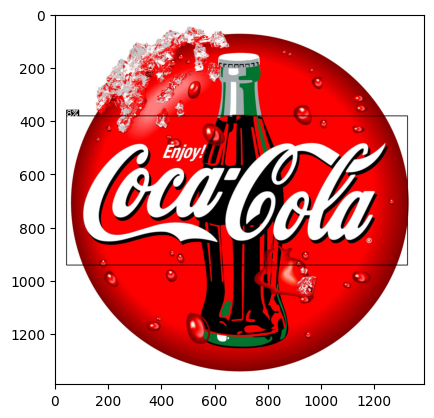

In [7]:
detect_template(TEMPLATE_PATH, IMAGES_PATH + 'coca_logo_1.png', True)
detect_template(TEMPLATE_PATH, IMAGES_PATH + 'coca_logo_2.png', True)
detect_template(TEMPLATE_PATH, IMAGES_PATH + 'coca_multi.png', True)
detect_template(TEMPLATE_PATH, IMAGES_PATH + 'coca_retro_1.png', True)
detect_template(TEMPLATE_PATH, IMAGES_PATH + 'coca_retro_2.png', True)
detect_template(TEMPLATE_PATH, IMAGES_PATH + 'logo_1.png', True)
detect_template(TEMPLATE_PATH, IMAGES_PATH + 'COCA-COLA-LOGO.jpg', True)